# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [203]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import random
import os

## load data

In [204]:
#directory_data  = './data/'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [205]:
print('*************************************************')
print('number of classes :', len(set(y_train)))
print('*************************************************')

*************************************************
number of classes : 10
*************************************************


## hyper-parameters

In [206]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 100
size_minibatch  = 32
learning_rate   = 0.001
weight_decay    = 0.001

## custom data loader for the PyTorch framework

In [207]:
class dataset(Dataset):
    
    def __init__(self, image, label):
        
        self.image  = image
        self.label  = label.astype(np.long)
    
    def __getitem__(self, index):
        
        image   = self.image[index, :, :]
        label   = self.label[index, ]

        image   = torch.FloatTensor(image).unsqueeze(dim=0)
        label   = torch.LongTensor([label])

        return image, label
    
    def __len__(self):
        
        return self.image.shape[0]

    def collate_fn(self, batch):
        images  = list()
        labels  = list()

        for b in batch:
            images.append(b[0])
            labels.append(b[1])

        images  = torch.stack(images, dim=0)
        labels  = torch.stack(labels, dim=0).squeeze()

        return images, labels
        

## construct datasets and dataloaders for training and testing

In [221]:
#dataset_train   = dataset(x_train, y_train)
#dataset_test    = dataset(x_test, y_test)

#dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True)
#dataloader_test     = torch.utils.data.DataLoader(dataset_test, batch_size=size_minibatch, shuffle=True)
dataloader_train = 

## shape of the data when using the data loader

In [209]:
image, label = next(iter(dataloader_train))
print('************************************************************')
print('size of mini-batch of the image:', image.shape)
print('************************************************************')
print('size of mini-batch of the label:', label.shape)
print('************************************************************')

************************************************************
size of mini-batch of the image: torch.Size([32, 1, 32, 32])
************************************************************
size of mini-batch of the label: torch.Size([32, 1])
************************************************************


## class for the neural network 

In [302]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc1 = nn.Sequential(
                        nn.Linear(1024, 32), # hidden_layer2 = 32, hidden_layer3 = 16
                        nn.ReLU(),
                        nn.Linear(32, 16),
                        nn.ReLU(),
                        nn.Linear(16, 10), # hidden_layer3 = 16, output_layer = 10
                    )

    def forward(self, input):
        input = self.fc1(input)
        
        return input

## build network

In [303]:
classifier  = Classifier().to(device)
optimizer   = torch.optim.SGD(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay)

## print the defined neural network

In [304]:
print(classifier)

Classifier(
  (fc1): Sequential(
    (0): Linear(in_features=1024, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=10, bias=True)
  )
)


## compute the prediction

In [305]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the loss

In [306]:
def compute_loss(prediction, label):

    criterion   = nn.CrossEntropyLoss()
    loss        = criterion(prediction, label)
    loss_value  = loss.item()

    return loss, loss_value

## compute the accuracy

In [307]:
def compute_accuracy(prediction, label):

    y_pred = torch.argmax(prediction, dim=1)
    return (y_pred == label).to(torch.float).mean().item()

## variables for the learning curve

In [308]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

## train and test

In [310]:
for i in tqdm(range(number_epoch)):
    
    loss_train_epoch        = []
    accuracy_train_epoch    = []

    classifier.train()

    for index_batch, (image_train, label_train) in enumerate(dataloader_train):

        if (index_batch == 32):
            break
        image_train = image_train.to(device)
        label_train = label_train.to(device)
        image_train = image_train.reshape(32, 1 *32 * 32)
        prediction_train = compute_prediction(classifier, image_train)
        label_train = label_train.reshape(32)
        loss_train, loss_value_train    = compute_loss(prediction_train, label_train)
        accuracy_train                  = compute_accuracy(prediction_train, label_train)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        loss_train_epoch.append(loss_value_train)
        accuracy_train_epoch.append(accuracy_train)

    loss_mean_train[i]      = np.mean(loss_train_epoch)
    loss_std_train[i]       = np.std(loss_train_epoch)

    accuracy_mean_train[i]  = np.mean(accuracy_train_epoch)
    accuracy_std_train[i]   = np.std(accuracy_train_epoch)

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    loss_test_epoch        = []
    accuracy_test_epoch    = []

    classifier.eval()

    for index_batch, (image_test, label_test) in enumerate(dataloader_test):
        if(index_batch == 32):
            break
        image_test = image_test.to(device)
        label_test = label_test.to(device)
        image_test = image_test.reshape(32, 1 *32 * 32)
        prediction_test             = compute_prediction(classifier, image_test)
        label_test = label_test.reshape(32)
        loss_test, loss_value_test  = compute_loss(prediction_test, label_test)
        accuracy_test               = compute_accuracy(prediction_test, label_test)

        loss_test_epoch.append(loss_value_test)
        accuracy_test_epoch.append(accuracy_test)

    loss_mean_test[i]      = np.mean(loss_test_epoch)
    loss_std_test[i]       = np.std(loss_test_epoch)

    accuracy_mean_test[i]  = np.mean(accuracy_test)
    accuracy_std_test[i]   = np.std(accuracy_test)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.81it/s]


## plot curve

In [311]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [312]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [313]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [314]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [315]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [316]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [317]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [318]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [319]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [320]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [321]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [322]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [323]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [324]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [325]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

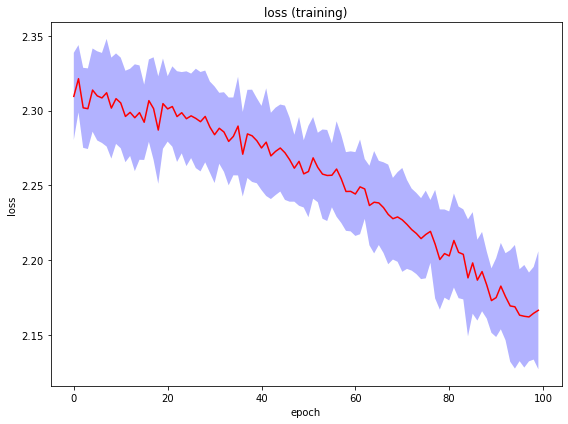

In [326]:
function_result_01()

## # 02. plot the training accuracy curve (mean, std)

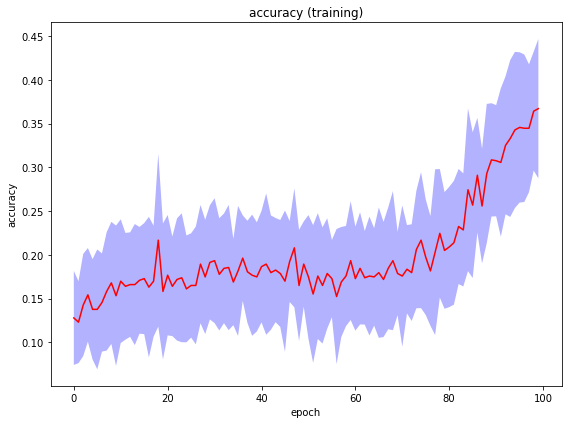

In [327]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

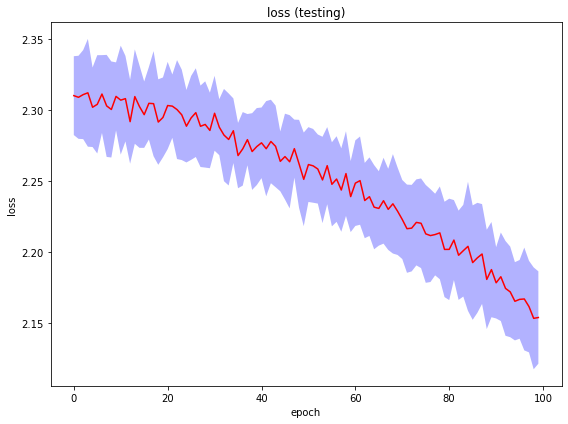

In [328]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

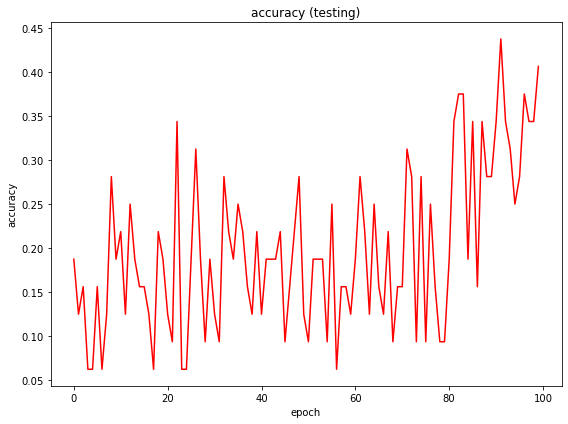

In [329]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [330]:
function_result_05()

index =  0, value = 2.1748904586
index =  1, value = 2.1825835630
index =  2, value = 2.1754850596
index =  3, value = 2.1693059355
index =  4, value = 2.1687514633
index =  5, value = 2.1631277725
index =  6, value = 2.1623941883
index =  7, value = 2.1619552672
index =  8, value = 2.1644271091
index =  9, value = 2.1664088070


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [331]:
function_result_06()

index =  0, value = 0.3076171875
index =  1, value = 0.3056640625
index =  2, value = 0.3251953125
index =  3, value = 0.3330078125
index =  4, value = 0.3427734375
index =  5, value = 0.3457031250
index =  6, value = 0.3447265625
index =  7, value = 0.3447265625
index =  8, value = 0.3642578125
index =  9, value = 0.3671875000


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [332]:
function_result_07()

index =  0, value = 2.1785561740
index =  1, value = 2.1828067228
index =  2, value = 2.1746064425
index =  3, value = 2.1721616983
index =  4, value = 2.1655568406
index =  5, value = 2.1669057310
index =  6, value = 2.1671733335
index =  7, value = 2.1618335471
index =  8, value = 2.1535558403
index =  9, value = 2.1541479304


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [333]:
function_result_08()

index =  0, value = 0.3437500000
index =  1, value = 0.4375000000
index =  2, value = 0.3437500000
index =  3, value = 0.3125000000
index =  4, value = 0.2500000000
index =  5, value = 0.2812500000
index =  6, value = 0.3750000000
index =  7, value = 0.3437500000
index =  8, value = 0.3437500000
index =  9, value = 0.4062500000


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [334]:
function_result_09()

best training accuracy = 0.3671875000


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [335]:
function_result_10()

best testing accuracy = 0.4375000000
